# Recommender System

A streamlined recommender system framework with NLP capabilities for easy experimentation.

## Installation

1. Install core dependencies:

```bash
pip install polars catboost optuna scikit-learn pandas numpy
```

2. Install NLP dependencies:

```bash
pip install sentence-transformers
```

## Project Structure

The  framework consists of these key components:

- `data_loader.py` - Handles data loading and time-based splitting
- `experiment.py` - Manages the experiment lifecycle
- `hyperparameter_tuner.py` - Provides optional parameter tuning
- `text_processor.py` - Processes text features using pretrained models
- `feature_factory.py` - Generates features, handles dependencies, keeps track of categorical columns
- `model_factory.py` - Model factory



## Basic Usage

```python
from lavka_recsys import Config, Experiment, register_text_embedding_features

# Allows use of NLP features ("product_embeddings", "category_embeddings", etc) 
register_text_embedding_features()

# Create configuration
config = Config({
    "experiment_name": "simple_recommender",
    "model": {
        "type": "catboost",
        "config": {
            "catboost": {
                "iterations": 500,
                "learning_rate": 0.1,
                "depth": 6
            }
        }
    },
    "features": [
        "count_purchase_user_product",
        "ctr_product",
        "user_stats", 
        "product_stats",
        "store_stats",
        "product_embeddings",
        "category_embeddings"
    ],
    "target": "CartUpdate_Purchase_vs_View",
    "data": {
        "train_path": "data/train.parquet",
        "test_path": "data/test.parquet"
    },
    "text_processing": {
        "model_type": "sentence-transformers",
        "model_name": "all-MiniLM-L6-v2",
        "embedding_dimensions": 20
    }
})

# Create and run experiment
experiment = SimpleExperiment("my_experiment", config)
results = experiment.run()
print(f"Metrics: {results['metrics']}")

# Generate predictions
submission = experiment.predict()
```

## Text Feature Options

The system supports multiple pretrained NLP models:

1. **Sentence Transformers** (recommended):
   - Modern, transformer-based embeddings
   - Configuration: `"model_type": "sentence-transformers"`
   - Good models: `"all-MiniLM-L6-v2"` (small), `"all-mpnet-base-v2"` (larger but better)

2. **Word2Vec** (optional):
   - Classic word embeddings
   - Configuration: `"model_type": "word2vec"`
   - Good models: `"glove-wiki-gigaword-100"`, `"word2vec-google-news-300"`


## Hyperparameter Tuning

To run with hyperparameter tuning:

```python
results = experiment.run_with_tuning()
best_params = results['best_params']
submission = experiment.predict(best_params)
```

## Customization

For custom feature engineering, simply add your feature generators to the `feature_factory.py` file as you've been doing.

## Memory Requirements

- **Base System**: ~2GB RAM
- **With Sentence Transformers**: ~3GB RAM (depends on model size)
- **With Word2Vec**: ~2.5GB RAM

## Troubleshooting

- If you encounter memory issues, try a smaller model or reduce embedding dimensions
- For faster debugging, set `"data.sample_fraction": 0.1` in your configuration

In [1]:
from datetime import datetime

In [2]:
%load_ext autoreload
%autoreload 2
from lavka_recsys import Config, Experiment, setup_logging, Visualizer, FeatureFactory, FeatureSelector, DataLoader

In [3]:
config_dict = {
    "experiment_name": "simple_recommender",
    "model": {
        "type": "catboost",
        "config": {
            "catboost": {
                "iterations": 500,
                "learning_rate": 0.1,
                "depth": 6,
                "verbose": 100
            }
        }
    },
    "features": [
        "count_purchase_user_product",
        # "count_purchase_user_store",
        "ctr_product", 
        "user_stats",
        "product_stats",
        "store_stats",
        # "city_stats",
        "recency_user_product",
        "recency_user_store",
        "time_features",
        "time_window_user_product",
        "product_temporal_patterns",
        # "session_features",
        "frequency_features",
        "product_popularity_trend",
        "cross_features",
        "user_segments",
        "memory-based-cf",
        "npmi-cf",
        "svd-cf",
        "puresvd-cf",

        # NLP embeddings
        # "product_embeddings",
        # "category_embeddings"
    ],
    "target": "CartUpdate_vs_View",
    "data": {
        "train_path": "data/train.parquet",
        "test_path": "data/test.parquet",
        "sample_fraction": None  # Use full dataset (or set to a number for testing)
    },
    # "output": {
    #     "results_dir": "results",
    #     "save_model": True,
    #     "save_predictions": True
    # },
    # Text processing with pretrained model
    "text_processing": {
        "model_type": "sentence-transformers",
        "model_name": "paraphrase-multilingual-MiniLM-L12-v2",  # Small but effective model
        "embedding_dimensions": 20
    },
    "feature_selection": {
        "enabled": True,
        "method": "importance",
        # "threshold": 0.05,
        "n_features": 20
    }
}

In [4]:
config = Config(config_dict)
setup_logging(config);

In [5]:
config.config

{'model': {'type': 'catboost',
  'config': {'catboost': {'iterations': 500,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 3.0,
    'verbose': 100,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50}}},
 'features': ['count_purchase_user_product',
  'ctr_product',
  'user_stats',
  'product_stats',
  'store_stats',
  'recency_user_product',
  'recency_user_store',
  'time_features',
  'time_window_user_product',
  'product_temporal_patterns',
  'frequency_features',
  'product_popularity_trend',
  'cross_features',
  'user_segments',
  'memory-based-cf',
  'npmi-cf',
  'svd-cf',
  'puresvd-cf'],
 'target': 'CartUpdate_vs_View',
 'data': {'train_path': 'data/train.parquet',
  'test_path': 'data/test.parquet',
  'sample_size': None,
  'sample_fraction': None},
 'text_processing': {'model_type': 'sentence-transformers',
  'model_name': 'paraphrase-multilingual-MiniLM-L12-v2',
  'embedding_dimensions': 20},
 'output': {'results_dir': 're

In [ ]:
# Create experiment
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_name = f"recommender_{timestamp}"

experiment = Experiment(experiment_name, config)
print(f"Starting experiment: {experiment_name}")
experiment.setup()

# Choose one of these options:
    
# Option 1: Run without hyperparameter tuning (fastest)
results = experiment.run()

# Option 2: Run with hyperparameter tuning (better results)
# results = experiment.run_with_tuning()
    
print(f"Experiment metrics: {results['metrics']}")

2025-04-13 22:43:35,463 - lavka_recsys.Experiment(recommender_20250413_224335_36eae2) - INFO - Saved configuration to results/recommender_20250413_224335_36eae2_config.json
Starting experiment: recommender_20250413_224335
2025-04-13 22:43:36,129 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-13 22:43:36,130 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
2025-04-13 22:43:36,130 - lavka_recsys.Experiment(recommender_20250413_224335_36eae2) - INFO - Training feature selector
2025-04-13 22:43:38,811 - lavka_recsys.DataLoader - INFO - Final split: history until [(2023-12-31 20:53:44 UTC.strict_cast(Datetime(Microseconds, None))) - (30d.alias("duration"))]
2025-04-13 22:43:38,811 - lavka_recsys.DataLoader - INFO - Final training: [(2023-12-31 20:53:44 UTC.strict_cast(Datetime(Microseconds, None))) - (30d.alias("duration"))] to 2023-12-31 20:53:44
2025-04-13 22:43:38,812 - lavka_recsys.DataLoader - INFO - Final split data: 13444142 history, 15102

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.1s


Top 25 most important features:
cf_score: 12.127480
npmi_cf_score: 6.731814
mean_interval_days: 6.143943
product_total_views: 5.812960
product_total_purchases: 5.736457
user_total_interactions: 5.256388
user_total_views: 4.671270
count_purchase_u_p: 4.496938
product_total_interactions: 4.051443
purchases_month_u_p: 3.762151
user_total_purchases: 3.222825
views_month_u_p: 2.995067
user_unique_products: 2.894743
svd_cf_score: 2.370428
puresvd_cf_score: 2.341202
user_store_purchase_cross: 2.182171
user_product_store_cross: 2.071863
store_unique_products: 1.771581
user_product_purchase_cross: 1.565548
interactions_month_u_p: 1.559316
store_total_interactions: 1.514922
product_unique_users: 1.460132
hour_of_day: 1.260635
purchase_trend: 1.222713
store_total_purchases: 1.191778


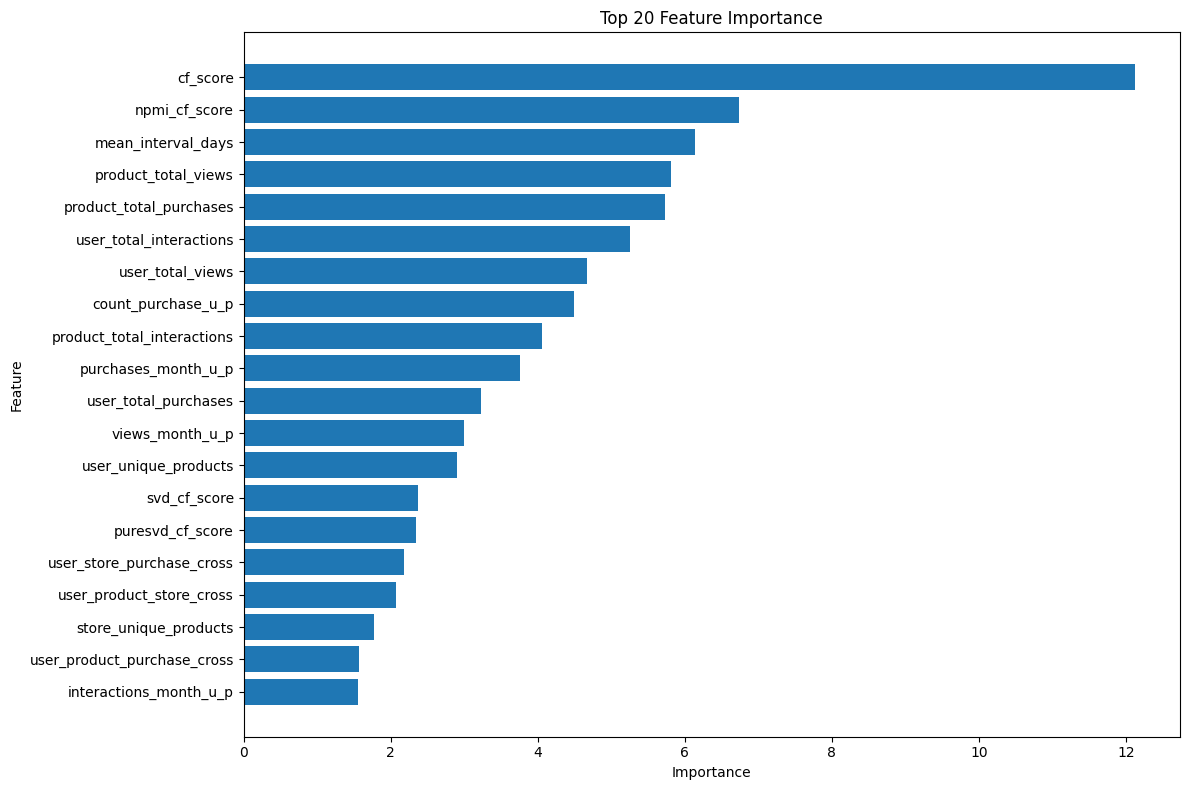

In [ ]:
# Print top 10 most important features
print("Top 10 most important features:")
top_features = sorted(
    results['feature_importance'].items(), 
    key=lambda x: x[1], 
    reverse=True
)[:10]

for feature, importance in top_features:
    print(f"{feature}: {importance:.6f}")

vis = Visualizer.plot_feature_importance(results['feature_importance'])


In [9]:
# best_params = results.get('best_params')  # Will be None if using run() without tuning
best_params = {'iterations': 189}
submission = experiment.predict(best_params)

print(f"\nPredictions generated. First 5 rows:")
print(submission.head(10))

print(f"\nExperiment completed: {experiment_name}")

2025-04-13 21:47:16,786 - lavka_recsys.experiment=recommender_20250413_214129 - INFO - Training final model for prediction
2025-04-13 21:47:21,642 - lavka_recsys.DataLoader - INFO - Final split: history until [(2023-12-31 20:53:44 UTC.strict_cast(Datetime(Microseconds, None))) - (30d.alias("duration"))]
2025-04-13 21:47:21,646 - lavka_recsys.DataLoader - INFO - Final training: [(2023-12-31 20:53:44 UTC.strict_cast(Datetime(Microseconds, None))) - (30d.alias("duration"))] to 2023-12-31 20:53:44
2025-04-13 21:47:21,647 - lavka_recsys.DataLoader - INFO - Final split data: 13444142 history, 1510275 train rows
2025-04-13 21:47:21,647 - lavka_recsys.FeatureFactory - INFO - Generating features: count_purchase_user_product, ctr_product, user_stats, product_stats, store_stats, recency_user_product, recency_user_store, time_features, time_window_user_product, product_temporal_patterns, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, svd-cf, 

In [10]:
submission['predict'].describe()

statistic,value
str,f64
"""count""",565231.0
"""null_count""",0.0
"""mean""",0.020185
"""std""",0.02335
"""min""",0.000767
"""25%""",0.009392
"""50%""",0.013311
"""75%""",0.021335
"""max""",0.618228
